# Using the MNIST256 data set

In [62]:
import torch
import torchvision

from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader

from PIL import Image
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from tqdm import tqdm

from tsputils import input_x_gradient, integrated_gradients, project_into_tangent_space

In [26]:
device = "cuda"

## Load the data 

In [4]:
transform = torchvision.transforms.Compose([torchvision.transforms.ToTensor(),
                                            torchvision.transforms.Grayscale()])

trainset = ImageFolder('/home/sebastian/mnist256/train', transform = transform)
trainloader = DataLoader(trainset, batch_size=128, shuffle=True, num_workers=8)

valset = ImageFolder('/home/sebastian//mnist256/val', transform = transform)
valloader = DataLoader(valset, batch_size=128, shuffle=False, num_workers=8)

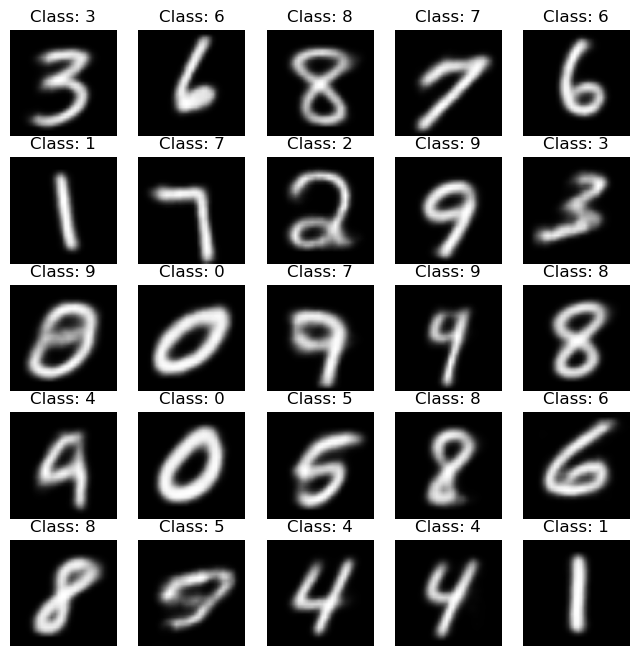

In [17]:
# visualize examples from the training data
fix, axs = plt.subplots(5, 5, figsize=(8, 8))
for i in range(5):
    for j in range(5):
        img, c = iter(trainloader).__next__()
        axs[i,j].imshow(img[0, 0, :, :], cmap='gray', interpolation='none')
        axs[i,j].set_title(f'Class: {c[0]}')
        axs[i,j].axis('off')
plt.show()

## Train a model

In [44]:
model = torchvision.models.resnet18()
model.conv1 = torch.nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False) # a single input channel
model.fc = torch.nn.Linear(512, 10) # 10-class problem
model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-2)
ce_loss = torch.nn.CrossEntropyLoss()

In [45]:
for i_epoch in range(5):    
    model.train()
    train_loss, train_zero_one_loss = 0, 0
    for img, label in tqdm(trainloader):
        img, label = img.to(device), label.to(device)
        pred = model(img)
        optimizer.zero_grad()
        loss = ce_loss(pred, label)
        loss.backward()
        train_loss += loss.item()  
        train_zero_one_loss += (pred.softmax(dim=1).argmax(dim=1) != label).sum().item()
        optimizer.step()
    print(f'Epoch {i_epoch}: Train Loss: {train_loss / len(trainloader.dataset)}  Train Error: {train_zero_one_loss / len(trainloader.dataset)}')
    model.eval()
    test_loss, test_zero_one_loss = 0, 0
    for img, label in valloader:
        img, label = img.to(device), label.to(device)
        pred = model(img)
        test_loss += loss.item()  
        test_zero_one_loss += (pred.softmax(dim=1).argmax(dim=1) != label).sum().item()
    print(f'Epoch {i_epoch}: Test Loss: {test_loss / len(trainloader.dataset)}  Test Error: {test_zero_one_loss / len(trainloader.dataset)}')

100%|██████████| 469/469 [02:10<00:00,  3.60it/s]

Epoch 0: Train Loss: 0.002645526865310967  Train Error: 0.10696666666666667


Epoch 0: Test Loss: 0.011597590645154317  Test Error: 0.005366666666666666


100%|██████████| 469/469 [02:12<00:00,  3.54it/s]

Epoch 1: Train Loss: 0.000562246056389995  Train Error: 0.024083333333333335


Epoch 1: Test Loss: 0.010506651798884074  Test Error: 0.0032


 31%|███       | 144/469 [00:41<01:34,  3.46it/s]


KeyboardInterrupt: 

In [5]:
# save the model
torch.save(model.state_dict(), 'mnist_resnet18.pth')

NameError: name 'model' is not defined

In [6]:
# load the model
model = torchvision.models.resnet18()
model.conv1 = torch.nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False) # a single input channel
model.fc = torch.nn.Linear(512, 10) # 10-class problem
model.load_state_dict(torch.load('mnist_resnet18.pth'))
model.to(device)

ResNet(
  (conv1): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

## Compute feature attributions

In [63]:
valloader = DataLoader(valset, batch_size=1, shuffle=False, num_workers=8) # load one image at a time and don't shuffle

igx_list, int_grad_list = [], []
model.eval()
for idx, (img, label) in tqdm(enumerate(valloader)):
    img, label = img.to(device), label.to(device)
    ixg = input_x_gradient(model, img, target=label, device=device)
    igx_list.append(ixg)
    int_grad = integrated_gradients(model, img, target=label, device=device)
    int_grad_list.append(int_grad)

8000it [11:25, 11.67it/s]


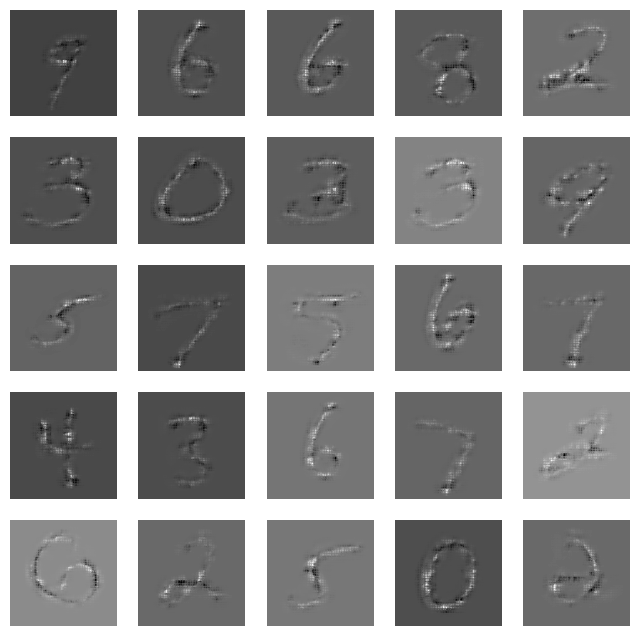

In [73]:
# visualize the attributions
fix, axs = plt.subplots(5, 5, figsize=(8, 8))
for i in range(5):
    for j in range(5):
        idx = np.random.randint(0, 8000)
        attr = igx_list[idx]
        axs[i,j].imshow(attr, cmap='gray', interpolation='none')
        axs[i,j].axis('off')
plt.show()

## The alignment of attributions with the tangent space

In [66]:
def load_minst256_tanget_space(root, val_img_idx):
    """Load the tangent space of a single image from the MNIST256 validaiton set."""
    tsp = np.zeros((8, 256, 256))
    for dim in range(8):
        fname = f'{root}/tsp/{val_img_idx}/dim{dim}.png'
        img = Image.open(fname)
        tsp[dim, :, :] = np.array(img) / 127.5 - 1 
    return tsp

In [67]:
frac_ixg_its = []
frac_int_grad_its = []
for idx in tqdm(range(8000)):
    # load the tanget space of the validation image
    tanget_space = load_minst256_tanget_space('/home/sebastian/mnist256', idx)

    # compute projections into tangent space, and fraction in tangent space
    projection = project_into_tangent_space(tanget_space, igx_list[idx])
    frac_ixg_its.append(np.linalg.norm(projection.flatten()) / np.linalg.norm(igx_list[idx].flatten()))
    projection = project_into_tangent_space(tanget_space, int_grad_list[idx])
    frac_int_grad_its.append(np.linalg.norm(projection.flatten()) / np.linalg.norm(int_grad_list[idx].flatten()))

100%|██████████| 8000/8000 [01:32<00:00, 86.67it/s]


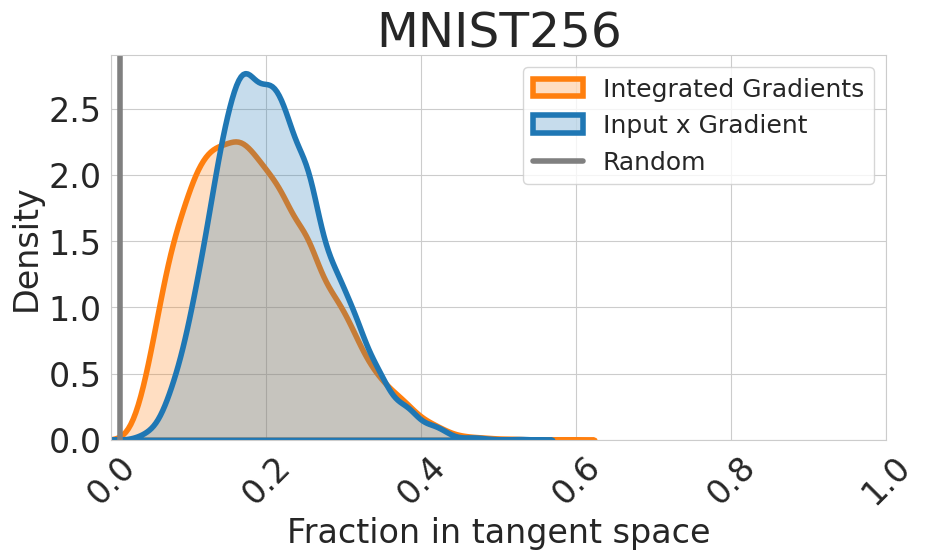

In [68]:
val_pair = []
for v in frac_ixg_its:
    val_pair.append((v, 'Input X Gradient'))
for v in frac_int_grad_its:
    val_pair.append((v, 'Integrated Gradients'))
df = pd.DataFrame(data=val_pair, columns=['Value', 'Method'])
sns.set_style('whitegrid')

plt.figure(figsize=(10, 5))
sns.kdeplot(data=df, x='Value', hue='Method', fill=True, legend=False, lw=4, alpha=0.25)
plt.axvline(np.sqrt(8 / 256**2), 0, 1.4, label='Random', color='gray', lw=4)
plt.legend(labels=['Integrated Gradients', 'Input x Gradient', 'Random'], fontsize=18)
plt.xlim([0., 1.0])
plt.xticks(fontsize=24, rotation=45)
plt.xlabel('Fraction in tangent space', fontsize=24)
plt.yticks(fontsize=24)
plt.ylabel('Density', fontsize=24)
plt.title('MNIST256', fontsize=35)
plt.show()